# Rated DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [5]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [6]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [24]:
import numpy as np
rewards = [each[3] for each in batch]
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.0


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [25]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [26]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [27]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [28]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG: r+(gamma*nextQ)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=rates)) # 0-1
    dlossA /= 2
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [29]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [30]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [31]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [32]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [52]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [53]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [54]:
goal = 500
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/goal
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        num_step = 0 # reset

In [55]:
idx = np.random.choice(np.arange(memory_size// batch_size))
batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
rates = np.array([each[5] for each in batch])
batch = batch[rates >= (np.max(rates)*0.9)]
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])
rates = np.array([each[5] for each in batch])

In [56]:
batch.shape, \
states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape

((66, 6), (66, 4), (66,), (66, 4), (66,), (66,), (66,))

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [57]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dlossA_list, dlossQ_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111):
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        total_reward = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the last played episode
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair
            
            # Training using a max rated batch
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])
                if (np.max(rates)*0.9) > 0: # non-rated data -1
                    break
            batch = batch[rates >= (np.max(rates)*0.9)]
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rates = np.array([each[5] for each in batch])            
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA, model.d_optQ],
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dlossA_list.append([ep, np.mean(dlossA_batch)])
        dlossQ_list.append([ep, np.mean(dlossQ_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= goal:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 gloss:0.6487 dlossA:0.7176 dlossQ:0.7791 exploreP:0.9983
Episode:1 meanR:20.5000 R:24.0000 rate:0.0480 gloss:0.6516 dlossA:0.7274 dlossQ:0.7762 exploreP:0.9959
Episode:2 meanR:20.3333 R:20.0000 rate:0.0400 gloss:0.6557 dlossA:0.7273 dlossQ:0.7804 exploreP:0.9940
Episode:3 meanR:20.5000 R:21.0000 rate:0.0420 gloss:0.6638 dlossA:0.7314 dlossQ:0.7767 exploreP:0.9919
Episode:4 meanR:21.4000 R:25.0000 rate:0.0500 gloss:0.6516 dlossA:0.7231 dlossQ:0.7868 exploreP:0.9895
Episode:5 meanR:19.8333 R:12.0000 rate:0.0240 gloss:0.6518 dlossA:0.7304 dlossQ:0.7834 exploreP:0.9883
Episode:6 meanR:21.1429 R:29.0000 rate:0.0580 gloss:0.6381 dlossA:0.7186 dlossQ:0.8007 exploreP:0.9855
Episode:7 meanR:23.3750 R:39.0000 rate:0.0780 gloss:0.6706 dlossA:0.7294 dlossQ:0.7866 exploreP:0.9817
Episode:8 meanR:22.4444 R:15.0000 rate:0.0300 gloss:0.6852 dlossA:0.7277 dlossQ:0.7918 exploreP:0.9802
Episode:9 meanR:24.7000 R:45.0000 rate:0.0900 gloss:0.6590 dlossA:0.7321 

Episode:79 meanR:29.4250 R:48.0000 rate:0.0960 gloss:0.6592 dlossA:0.7268 dlossQ:0.8164 exploreP:0.7924
Episode:80 meanR:29.6173 R:45.0000 rate:0.0900 gloss:0.6716 dlossA:0.7316 dlossQ:0.8144 exploreP:0.7888
Episode:81 meanR:29.5244 R:22.0000 rate:0.0440 gloss:0.6413 dlossA:0.7137 dlossQ:0.8247 exploreP:0.7871
Episode:82 meanR:29.9759 R:67.0000 rate:0.1340 gloss:0.6669 dlossA:0.7253 dlossQ:0.8249 exploreP:0.7819
Episode:83 meanR:30.7500 R:95.0000 rate:0.1900 gloss:0.6614 dlossA:0.7232 dlossQ:0.8235 exploreP:0.7746
Episode:84 meanR:30.8000 R:35.0000 rate:0.0700 gloss:0.6532 dlossA:0.7209 dlossQ:0.8220 exploreP:0.7720
Episode:85 meanR:30.6628 R:19.0000 rate:0.0380 gloss:0.6665 dlossA:0.7239 dlossQ:0.8259 exploreP:0.7705
Episode:86 meanR:30.7011 R:34.0000 rate:0.0680 gloss:0.6692 dlossA:0.7300 dlossQ:0.8194 exploreP:0.7679
Episode:87 meanR:30.6250 R:24.0000 rate:0.0480 gloss:0.6767 dlossA:0.7331 dlossQ:0.8192 exploreP:0.7661
Episode:88 meanR:30.5393 R:23.0000 rate:0.0460 gloss:0.6644 dlos

Episode:158 meanR:38.9400 R:57.0000 rate:0.1140 gloss:0.6755 dlossA:0.7258 dlossQ:0.8418 exploreP:0.5773
Episode:159 meanR:39.1900 R:41.0000 rate:0.0820 gloss:0.6750 dlossA:0.7248 dlossQ:0.8520 exploreP:0.5749
Episode:160 meanR:39.5000 R:46.0000 rate:0.0920 gloss:0.6675 dlossA:0.7214 dlossQ:0.8511 exploreP:0.5723
Episode:161 meanR:39.6700 R:28.0000 rate:0.0560 gloss:0.6776 dlossA:0.7221 dlossQ:0.8570 exploreP:0.5708
Episode:162 meanR:39.8200 R:48.0000 rate:0.0960 gloss:0.6726 dlossA:0.7256 dlossQ:0.8435 exploreP:0.5681
Episode:163 meanR:40.7300 R:150.0000 rate:0.3000 gloss:0.6810 dlossA:0.7269 dlossQ:0.8583 exploreP:0.5598
Episode:164 meanR:41.2300 R:82.0000 rate:0.1640 gloss:0.6703 dlossA:0.7226 dlossQ:0.8604 exploreP:0.5553
Episode:165 meanR:42.0200 R:117.0000 rate:0.2340 gloss:0.6717 dlossA:0.7239 dlossQ:0.8530 exploreP:0.5489
Episode:166 meanR:42.3000 R:39.0000 rate:0.0780 gloss:0.6782 dlossA:0.7215 dlossQ:0.8587 exploreP:0.5468
Episode:167 meanR:42.9300 R:81.0000 rate:0.1620 gloss

Episode:236 meanR:128.4100 R:340.0000 rate:0.6800 gloss:0.8408 dlossA:0.8237 dlossQ:0.8135 exploreP:0.1851
Episode:237 meanR:128.6900 R:78.0000 rate:0.1560 gloss:0.8494 dlossA:0.8453 dlossQ:0.8156 exploreP:0.1838
Episode:238 meanR:132.5100 R:471.0000 rate:0.9420 gloss:0.8565 dlossA:0.8375 dlossQ:0.8130 exploreP:0.1758
Episode:239 meanR:133.0800 R:78.0000 rate:0.1560 gloss:0.8536 dlossA:0.8395 dlossQ:0.8069 exploreP:0.1745
Episode:240 meanR:137.5900 R:500.0000 rate:1.0000 gloss:0.8703 dlossA:0.8397 dlossQ:0.8049 exploreP:0.1665
Episode:241 meanR:140.5200 R:342.0000 rate:0.6840 gloss:0.8777 dlossA:0.8516 dlossQ:0.7992 exploreP:0.1612
Episode:242 meanR:140.8100 R:101.0000 rate:0.2020 gloss:0.8879 dlossA:0.8579 dlossQ:0.7950 exploreP:0.1597
Episode:243 meanR:143.7400 R:324.0000 rate:0.6480 gloss:0.8934 dlossA:0.8549 dlossQ:0.7929 exploreP:0.1549
Episode:244 meanR:143.9700 R:113.0000 rate:0.2260 gloss:0.9042 dlossA:0.8668 dlossQ:0.7944 exploreP:0.1533
Episode:245 meanR:146.4200 R:261.0000 r

Episode:313 meanR:308.7100 R:177.0000 rate:0.3540 gloss:1.8448 dlossA:1.5609 dlossQ:0.8079 exploreP:0.0246
Episode:314 meanR:312.4300 R:500.0000 rate:1.0000 gloss:1.8551 dlossA:1.5381 dlossQ:0.8177 exploreP:0.0239
Episode:315 meanR:313.2600 R:259.0000 rate:0.5180 gloss:1.8969 dlossA:1.5148 dlossQ:0.7766 exploreP:0.0236
Episode:316 meanR:315.3600 R:328.0000 rate:0.6560 gloss:1.9166 dlossA:1.5891 dlossQ:0.7755 exploreP:0.0231
Episode:317 meanR:318.9700 R:412.0000 rate:0.8240 gloss:1.9195 dlossA:1.6103 dlossQ:0.8011 exploreP:0.0226
Episode:318 meanR:316.6900 R:272.0000 rate:0.5440 gloss:1.9526 dlossA:1.6131 dlossQ:0.8027 exploreP:0.0223
Episode:319 meanR:315.5300 R:384.0000 rate:0.7680 gloss:1.9483 dlossA:1.6041 dlossQ:0.8222 exploreP:0.0218
Episode:320 meanR:317.7500 R:314.0000 rate:0.6280 gloss:1.9850 dlossA:1.5875 dlossQ:0.7966 exploreP:0.0214
Episode:321 meanR:319.9800 R:280.0000 rate:0.5600 gloss:1.9992 dlossA:1.6587 dlossQ:0.8284 exploreP:0.0211
Episode:322 meanR:317.7100 R:273.0000

Episode:390 meanR:361.2000 R:476.0000 rate:0.9520 gloss:3.3966 dlossA:2.7801 dlossQ:1.8053 exploreP:0.0110
Episode:391 meanR:361.2500 R:500.0000 rate:1.0000 gloss:3.5161 dlossA:2.9363 dlossQ:1.5355 exploreP:0.0110
Episode:392 meanR:359.4400 R:319.0000 rate:0.6380 gloss:3.5824 dlossA:2.9575 dlossQ:1.7574 exploreP:0.0109
Episode:393 meanR:359.4400 R:500.0000 rate:1.0000 gloss:3.6113 dlossA:2.9527 dlossQ:1.5201 exploreP:0.0109
Episode:394 meanR:358.4200 R:347.0000 rate:0.6940 gloss:3.7369 dlossA:2.9161 dlossQ:1.5588 exploreP:0.0109
Episode:395 meanR:358.8000 R:382.0000 rate:0.7640 gloss:3.7974 dlossA:3.1884 dlossQ:1.7704 exploreP:0.0108
Episode:396 meanR:355.4200 R:162.0000 rate:0.3240 gloss:3.6482 dlossA:3.0908 dlossQ:1.6573 exploreP:0.0108
Episode:397 meanR:357.2500 R:413.0000 rate:0.8260 gloss:3.6132 dlossA:2.8049 dlossQ:1.7426 exploreP:0.0108
Episode:398 meanR:355.9800 R:373.0000 rate:0.7460 gloss:3.6404 dlossA:2.8696 dlossQ:1.9927 exploreP:0.0108
Episode:399 meanR:358.5400 R:454.0000

Episode:467 meanR:373.2200 R:216.0000 rate:0.4320 gloss:3.6858 dlossA:3.2992 dlossQ:2.5751 exploreP:0.0101
Episode:468 meanR:375.7900 R:490.0000 rate:0.9800 gloss:3.8718 dlossA:3.3529 dlossQ:2.2387 exploreP:0.0101
Episode:469 meanR:374.8400 R:222.0000 rate:0.4440 gloss:3.9301 dlossA:3.1799 dlossQ:1.8016 exploreP:0.0100
Episode:470 meanR:377.0300 R:500.0000 rate:1.0000 gloss:4.0679 dlossA:3.3160 dlossQ:2.2643 exploreP:0.0100
Episode:471 meanR:376.2100 R:276.0000 rate:0.5520 gloss:3.8867 dlossA:3.0121 dlossQ:3.1984 exploreP:0.0100
Episode:472 meanR:374.6600 R:345.0000 rate:0.6900 gloss:3.8230 dlossA:3.2511 dlossQ:2.0723 exploreP:0.0100
Episode:473 meanR:375.3500 R:500.0000 rate:1.0000 gloss:4.2149 dlossA:3.3542 dlossQ:2.5949 exploreP:0.0100
Episode:474 meanR:372.6600 R:231.0000 rate:0.4620 gloss:3.9709 dlossA:3.3328 dlossQ:2.0497 exploreP:0.0100
Episode:475 meanR:371.6400 R:313.0000 rate:0.6260 gloss:4.4373 dlossA:3.6035 dlossQ:2.8230 exploreP:0.0100
Episode:476 meanR:372.9800 R:422.0000

Episode:544 meanR:374.0000 R:500.0000 rate:1.0000 gloss:1.8531 dlossA:2.6006 dlossQ:1.5553 exploreP:0.0100
Episode:545 meanR:375.0600 R:292.0000 rate:0.5840 gloss:1.7795 dlossA:2.7880 dlossQ:2.3442 exploreP:0.0100
Episode:546 meanR:377.0400 R:487.0000 rate:0.9740 gloss:1.7007 dlossA:2.6005 dlossQ:1.8963 exploreP:0.0100
Episode:547 meanR:376.3900 R:357.0000 rate:0.7140 gloss:1.5830 dlossA:2.6701 dlossQ:1.9821 exploreP:0.0100
Episode:548 meanR:376.3900 R:500.0000 rate:1.0000 gloss:1.6061 dlossA:2.4396 dlossQ:1.6957 exploreP:0.0100
Episode:549 meanR:377.3900 R:336.0000 rate:0.6720 gloss:1.5927 dlossA:2.2748 dlossQ:1.9470 exploreP:0.0100
Episode:550 meanR:380.3400 R:500.0000 rate:1.0000 gloss:1.8222 dlossA:2.4117 dlossQ:1.8625 exploreP:0.0100
Episode:551 meanR:380.3400 R:500.0000 rate:1.0000 gloss:1.7152 dlossA:2.4658 dlossQ:2.3978 exploreP:0.0100
Episode:552 meanR:380.3400 R:500.0000 rate:1.0000 gloss:1.5652 dlossA:2.3598 dlossQ:2.7286 exploreP:0.0100
Episode:553 meanR:378.6500 R:272.0000

Episode:621 meanR:362.2600 R:244.0000 rate:0.4880 gloss:0.8102 dlossA:2.2857 dlossQ:1.6964 exploreP:0.0100
Episode:622 meanR:362.8700 R:373.0000 rate:0.7460 gloss:0.8175 dlossA:2.0305 dlossQ:0.9390 exploreP:0.0100
Episode:623 meanR:361.5600 R:346.0000 rate:0.6920 gloss:0.7774 dlossA:2.1123 dlossQ:0.9186 exploreP:0.0100
Episode:624 meanR:363.8700 R:500.0000 rate:1.0000 gloss:0.8193 dlossA:2.2587 dlossQ:1.3584 exploreP:0.0100
Episode:625 meanR:361.7900 R:258.0000 rate:0.5160 gloss:0.9018 dlossA:2.5778 dlossQ:0.8257 exploreP:0.0100
Episode:626 meanR:363.8300 R:432.0000 rate:0.8640 gloss:0.8345 dlossA:2.4596 dlossQ:0.9040 exploreP:0.0100
Episode:627 meanR:365.1800 R:500.0000 rate:1.0000 gloss:0.8617 dlossA:2.6506 dlossQ:1.5739 exploreP:0.0100
Episode:628 meanR:364.8400 R:449.0000 rate:0.8980 gloss:0.9354 dlossA:2.5474 dlossQ:1.5719 exploreP:0.0100
Episode:629 meanR:366.6500 R:500.0000 rate:1.0000 gloss:0.8751 dlossA:2.4978 dlossQ:1.9131 exploreP:0.0100
Episode:630 meanR:367.5500 R:427.0000

Episode:698 meanR:391.4600 R:500.0000 rate:1.0000 gloss:0.6357 dlossA:2.0009 dlossQ:1.0763 exploreP:0.0100
Episode:699 meanR:388.9900 R:253.0000 rate:0.5060 gloss:0.7201 dlossA:1.8400 dlossQ:0.9386 exploreP:0.0100
Episode:700 meanR:388.3500 R:294.0000 rate:0.5880 gloss:0.6600 dlossA:2.0664 dlossQ:1.3323 exploreP:0.0100
Episode:701 meanR:388.0400 R:366.0000 rate:0.7320 gloss:0.6410 dlossA:2.2098 dlossQ:1.7384 exploreP:0.0100
Episode:702 meanR:390.2600 R:395.0000 rate:0.7900 gloss:0.6236 dlossA:2.0685 dlossQ:1.5582 exploreP:0.0100
Episode:703 meanR:389.4700 R:421.0000 rate:0.8420 gloss:0.6783 dlossA:2.2168 dlossQ:0.7938 exploreP:0.0100
Episode:704 meanR:391.1200 R:500.0000 rate:1.0000 gloss:0.7009 dlossA:2.1863 dlossQ:1.1874 exploreP:0.0100
Episode:705 meanR:390.0000 R:318.0000 rate:0.6360 gloss:0.6301 dlossA:2.0923 dlossQ:1.5666 exploreP:0.0100
Episode:706 meanR:391.4700 R:500.0000 rate:1.0000 gloss:0.6841 dlossA:2.1067 dlossQ:1.5972 exploreP:0.0100
Episode:707 meanR:394.5400 R:500.0000

Episode:775 meanR:397.5000 R:500.0000 rate:1.0000 gloss:0.4972 dlossA:1.6536 dlossQ:1.4991 exploreP:0.0100
Episode:776 meanR:398.6600 R:500.0000 rate:1.0000 gloss:0.5173 dlossA:1.5645 dlossQ:1.0108 exploreP:0.0100
Episode:777 meanR:397.3300 R:367.0000 rate:0.7340 gloss:0.5836 dlossA:1.3524 dlossQ:1.5692 exploreP:0.0100
Episode:778 meanR:397.3900 R:500.0000 rate:1.0000 gloss:0.5968 dlossA:1.6129 dlossQ:1.5440 exploreP:0.0100
Episode:779 meanR:396.4100 R:333.0000 rate:0.6660 gloss:0.5763 dlossA:1.6532 dlossQ:1.3866 exploreP:0.0100
Episode:780 meanR:397.0400 R:383.0000 rate:0.7660 gloss:0.5246 dlossA:1.9774 dlossQ:1.7944 exploreP:0.0100
Episode:781 meanR:396.9200 R:240.0000 rate:0.4800 gloss:0.6338 dlossA:1.8562 dlossQ:1.4768 exploreP:0.0100
Episode:782 meanR:394.2100 R:229.0000 rate:0.4580 gloss:0.5285 dlossA:1.7435 dlossQ:0.8271 exploreP:0.0100
Episode:783 meanR:392.3600 R:241.0000 rate:0.4820 gloss:0.7021 dlossA:1.8016 dlossQ:0.8952 exploreP:0.0100
Episode:784 meanR:393.1900 R:500.0000

Episode:852 meanR:380.1100 R:339.0000 rate:0.6780 gloss:0.5060 dlossA:1.3424 dlossQ:1.5801 exploreP:0.0100
Episode:853 meanR:377.9700 R:286.0000 rate:0.5720 gloss:0.5009 dlossA:1.6303 dlossQ:1.8036 exploreP:0.0100
Episode:854 meanR:377.7300 R:296.0000 rate:0.5920 gloss:0.4936 dlossA:1.4263 dlossQ:1.5555 exploreP:0.0100
Episode:855 meanR:376.3600 R:361.0000 rate:0.7220 gloss:0.4890 dlossA:1.3205 dlossQ:2.2208 exploreP:0.0100
Episode:856 meanR:377.3500 R:292.0000 rate:0.5840 gloss:0.4545 dlossA:1.6535 dlossQ:1.1563 exploreP:0.0100
Episode:857 meanR:375.8500 R:189.0000 rate:0.3780 gloss:0.4336 dlossA:1.5082 dlossQ:1.0039 exploreP:0.0100
Episode:858 meanR:375.1200 R:241.0000 rate:0.4820 gloss:0.4724 dlossA:1.3788 dlossQ:1.1193 exploreP:0.0100
Episode:859 meanR:376.8900 R:500.0000 rate:1.0000 gloss:0.4805 dlossA:1.6790 dlossQ:1.5673 exploreP:0.0100
Episode:860 meanR:374.7900 R:212.0000 rate:0.4240 gloss:0.5038 dlossA:1.5550 dlossQ:1.4581 exploreP:0.0100
Episode:861 meanR:372.1600 R:237.0000

Episode:929 meanR:383.4000 R:468.0000 rate:0.9360 gloss:0.4990 dlossA:1.3771 dlossQ:1.6547 exploreP:0.0100
Episode:930 meanR:383.3500 R:349.0000 rate:0.6980 gloss:0.4705 dlossA:1.5250 dlossQ:1.3678 exploreP:0.0100
Episode:931 meanR:381.5700 R:322.0000 rate:0.6440 gloss:0.5085 dlossA:1.5185 dlossQ:2.1479 exploreP:0.0100
Episode:932 meanR:382.6400 R:343.0000 rate:0.6860 gloss:0.4584 dlossA:1.4852 dlossQ:1.9032 exploreP:0.0100
Episode:933 meanR:380.3400 R:201.0000 rate:0.4020 gloss:0.5758 dlossA:1.3911 dlossQ:2.3980 exploreP:0.0100
Episode:934 meanR:380.5300 R:361.0000 rate:0.7220 gloss:0.5574 dlossA:1.5990 dlossQ:2.4140 exploreP:0.0100
Episode:935 meanR:379.2100 R:210.0000 rate:0.4200 gloss:0.5266 dlossA:1.4544 dlossQ:2.3840 exploreP:0.0100
Episode:936 meanR:380.4200 R:500.0000 rate:1.0000 gloss:0.5074 dlossA:1.7141 dlossQ:2.2202 exploreP:0.0100
Episode:937 meanR:381.8300 R:500.0000 rate:1.0000 gloss:0.4864 dlossA:1.4707 dlossQ:2.0424 exploreP:0.0100
Episode:938 meanR:381.2600 R:284.0000

Episode:1006 meanR:365.9000 R:228.0000 rate:0.4560 gloss:0.3873 dlossA:1.2522 dlossQ:2.7697 exploreP:0.0100
Episode:1007 meanR:364.1400 R:262.0000 rate:0.5240 gloss:0.3688 dlossA:1.7104 dlossQ:10.7448 exploreP:0.0100
Episode:1008 meanR:363.6200 R:319.0000 rate:0.6380 gloss:0.3992 dlossA:1.1576 dlossQ:2.0134 exploreP:0.0100
Episode:1009 meanR:363.6900 R:258.0000 rate:0.5160 gloss:0.4330 dlossA:1.2951 dlossQ:1.1802 exploreP:0.0100
Episode:1010 meanR:361.2700 R:258.0000 rate:0.5160 gloss:0.3362 dlossA:1.2132 dlossQ:2.2261 exploreP:0.0100
Episode:1011 meanR:361.7600 R:500.0000 rate:1.0000 gloss:0.2850 dlossA:1.0273 dlossQ:1.1186 exploreP:0.0100
Episode:1012 meanR:361.8100 R:189.0000 rate:0.3780 gloss:0.3185 dlossA:1.2899 dlossQ:1.0911 exploreP:0.0100
Episode:1013 meanR:361.3300 R:448.0000 rate:0.8960 gloss:0.3301 dlossA:0.9487 dlossQ:1.4819 exploreP:0.0100
Episode:1014 meanR:360.2800 R:270.0000 rate:0.5400 gloss:0.3016 dlossA:1.0728 dlossQ:1.1121 exploreP:0.0100
Episode:1015 meanR:360.9600

Episode:1082 meanR:353.8200 R:361.0000 rate:0.7220 gloss:0.2916 dlossA:1.0478 dlossQ:1.2126 exploreP:0.0100
Episode:1083 meanR:352.3500 R:336.0000 rate:0.6720 gloss:0.3403 dlossA:1.1651 dlossQ:1.8608 exploreP:0.0100
Episode:1084 meanR:350.8300 R:205.0000 rate:0.4100 gloss:0.3526 dlossA:1.3199 dlossQ:2.8465 exploreP:0.0100
Episode:1085 meanR:350.2200 R:214.0000 rate:0.4280 gloss:0.3303 dlossA:1.1258 dlossQ:6.4634 exploreP:0.0100
Episode:1086 meanR:352.9200 R:500.0000 rate:1.0000 gloss:0.4093 dlossA:1.1569 dlossQ:1.8154 exploreP:0.0100
Episode:1087 meanR:355.8800 R:500.0000 rate:1.0000 gloss:0.3241 dlossA:1.0520 dlossQ:1.6919 exploreP:0.0100
Episode:1088 meanR:358.0100 R:500.0000 rate:1.0000 gloss:0.3023 dlossA:0.9761 dlossQ:1.5476 exploreP:0.0100
Episode:1089 meanR:357.5300 R:233.0000 rate:0.4660 gloss:0.3632 dlossA:1.2364 dlossQ:1.3034 exploreP:0.0100
Episode:1090 meanR:358.4700 R:500.0000 rate:1.0000 gloss:0.3904 dlossA:0.9604 dlossQ:1.3575 exploreP:0.0100
Episode:1091 meanR:358.4300 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

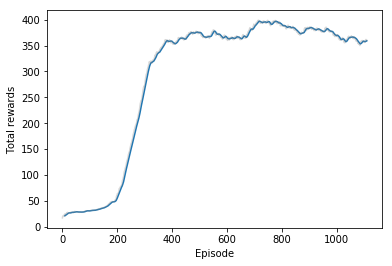

In [62]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

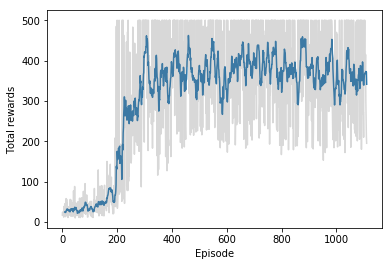

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [64]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

SyntaxError: invalid syntax (<ipython-input-64-a0b0af09d9f3>, line 6)

In [ ]:
eps, arr = np.array(dlossA_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

In [ ]:
eps, arr = np.array(dlossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.